# Lyapunov Exponent of Lorenz Attractor

# Import Packages

In [1]:
from scipy.integrate import odeint
import numpy as np
# %matplotlib
# %matplotlib widget
import matplotlib.pyplot as plt
import time, math
from mpl_toolkits import mplot3d

# Define ODEs of the system

In [2]:
def xdot_lorenz(x, t, sigma=10, r=28, b=8/3):
    """
    x is 3D
    """
    x0dot = sigma*(x[1]-x[0])
    x1dot = x[0]*(r-x[2])-x[1]
    x2dot = x[0]*x[1]-b*x[2]
    xdot = np.array([x0dot, x1dot, x2dot])
    
    return xdot

**Numerical Integration using odeint function**

In [3]:
dt = 0.01
t = np.arange(0, 100, dt)
T = len(t)
np.random.seed(0)
y0 = np.random.rand(3,)
y_t = odeint(xdot_lorenz, y0, t)

In [4]:
y_t.shape

(10000, 3)

In [5]:
T

10000

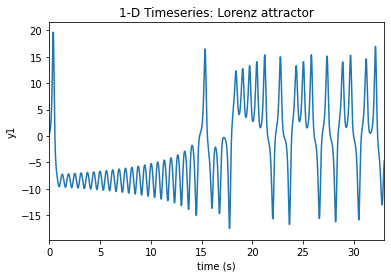

In [6]:
plt.plot(t, y_t[:,0])
plt.xlim(0,33)
plt.xlabel('time (s)')
plt.ylabel('y1')
plt.title('1-D Timeseries: Lorenz attractor')
plt.show()

In [7]:
y_t[0]

array([0.5488135 , 0.71518937, 0.60276338])

In [8]:
y_t.shape

(10000, 3)

# Obtain Reconstructed Phase Space with Delayed Coordinates

New delayed coordinates: $ (y_1(t), y_1(t+\tau), y_1(t+2\tau))$

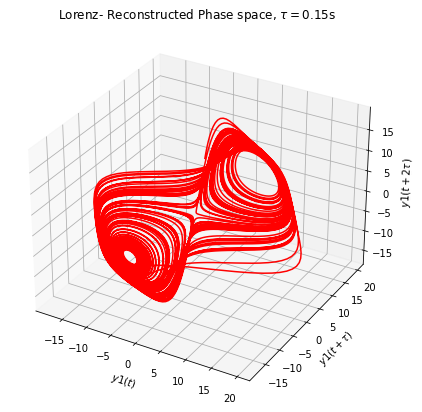

In [9]:
#construct delayed coordinates
y1_t = y_t[:,0] # observations
tau = 15# 7 is pretty good

yd = np.zeros((T-2*tau,3))

# samples = [y1_t[i] for i in range(len(y1_t)) if  i%tau==0]
# yd[:,0] = y1_t[:tau:]
yd[:,0] = y1_t[:T-2*tau]
yd[:,1] = y1_t[tau:T-tau] #y_{n-1}
# yd[-1*tau:,1] = yd[-1*tau-1,1]

yd[:, 2] = y1_t[2*tau:T]
# yd[-2*tau:, 2] = yd[-2*tau-1,1]

# visualize reconstructed phase space

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.plot(yd[:,0],yd[:,1],yd[:,2], color = "Red")

ax.set_xlabel(r'$y1(t)$')
ax.set_ylabel(r'$y1(t+\tau)$')
ax.set_zlabel(r'$y1(t+2\tau)$')
plt.title(r"Lorenz- Reconstructed Phase space, $\tau=$"+str(tau*dt)+'s')
# for angle in range(0, 360):
#    ax.view_init(30, angle)

plt.show()

**Visualize Actual and Reconstructed Phase Space**

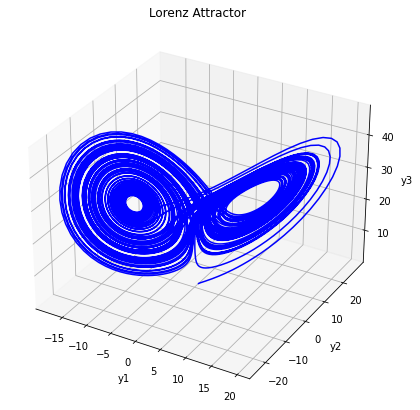

In [10]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.plot(y_t[:,0],y_t[:,1],y_t[:,2], color = "blue")
plt.title("Lorenz Attractor")
ax.set_xlabel('y1')
ax.set_ylabel('y2')
ax.set_zlabel('y3')

plt.show()

# Computing Lyapunov Exponents 

Fiducial Trajectory- $yd[0,:]$ to $yd[-1,:]$

Closest phase space point to a given fiducial point:

In [11]:
def closest_point(pointid, pointsAll):
    '''
    Closest point in phase space to a given point
    '''
    point = pointsAll[pointid, :]
    dist2 = np.sum((pointsAll - point)**2, axis=1)
    return np.argsort(dist2)[1] # second closest after itself

angle_thr= 1/3Finding Replacement Points:

(while preserving orientation and ensuring small enough length)

Fixed evolution time algorithm:

In [12]:
def fixed_time_evol(numsteps, fidloc, clos, yd):
    '''
    Fixed time evolution algorithm: allow separation distance to evolve for fixed number of timesteps
    '''
    fidloc_new = fidloc-1
    clos_new = clos-1
    lengths = []

    for i in range(numsteps+1): #first step computes initial distance
        fidloc_new += 1
        clos_new += 1
        newLen = np.linalg.norm(yd[fidloc_new, :]-yd[clos_new,:])
        lengths.append(newLen)
        
    
    return fidloc_new, clos_new, lengths

In [13]:
def presOrient(vectorInit, pos, pointsAll, thr=5, lmin=0.1, minimize='angle', angle_thr= 1/3):
    '''
    Choose replacement point to preserve orientations and minimize length
    
    pos: current fiducial point index
    vectorInit: the reference vector with whom the angle must be minimized
    '''
    if minimize=='angle':
        except_pos = [i for i in range(pointsAll.shape[0]) if i!=pos] 
        diffVec = pointsAll[except_pos,:]-pointsAll[pos,:] #so all indices after pos have new_ind=ind-1
        cosAll = np.dot(diffVec, vectorInit.reshape((-1,1))).flatten()/(np.linalg.norm(diffVec, axis=1)*np.linalg.norm(vectorInit))

        anglesAll = np.arccos(cosAll)

        anglesSortedInd = np.argsort(anglesAll) #indices which sort angles in ascending order
        lengths_angleSorted = np.linalg.norm(diffVec[anglesSortedInd, :], axis=1)
        suitable_len_ind = np.sort(np.argwhere((lengths_angleSorted)<thr)) #first location where length is acceptable
        replacement_pt = anglesSortedInd[suitable_len_ind[0]]

        if replacement_pt>=pos: #was after pos, so actual index = index+1
            replacement_pt+= 1
        i = 1
        while replacement_pt>= pointsAll.shape[0]-tevol:
            replacement_pt = anglesSortedInd[suitable_len_ind[i]]
            i+=1

        return replacement_pt
    
    elif minimize=='len':
        except_pos = [i for i in range(pointsAll.shape[0]) if i!=pos] 
        diffVec = pointsAll[except_pos,:]-pointsAll[pos,:] #so all indices after pos have new_ind=ind-1
        lenAll = np.linalg.norm(diffVec, axis=1)
        lenSortedInd = np.argsort(lenAll)
        cos_lenSorted = np.dot(diffVec[lenSortedInd, :], vectorInit.reshape((-1,1))).flatten()/(lenAll[lenSortedInd]*np.linalg.norm(vectorInit))
        angles_lenSorted = np.arccos(cos_lenSorted)
        
        suitable_angle_indices = np.sort(np.argwhere(angles_lenSorted<angle_thr))
        plausibleInd = lenSortedInd[suitable_angle_indices]
        
        try:
            # replacement_pt = lenSortedInd[suitable_angle_indices[0]]
            for i in range(len(plausibleInd)):
                if lenAll[plausibleInd[i]]>lmin:
                    replacement_pt = plausibleInd[i]
                    break
                    
        except IndexError:
            print(np.amin(angles_lenSorted))
        
        if replacement_pt>=pos: #was after pos, so actual index = index+1
            replacement_pt+= 1
        i = 1
        while replacement_pt>= pointsAll.shape[0]-tevol:
            replacement_pt = lenSortedInd[suitable_angle_indices[i]]
            i+=1

        return replacement_pt

**Putting it all together:**

(0.0, 0.32)

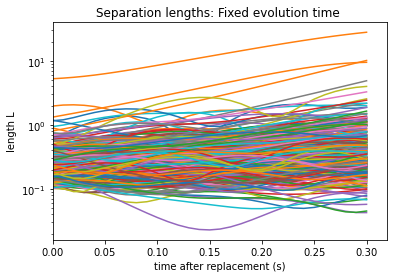

In [37]:
lengthsInit = [] #just after replacement- initial length
lengthsFinal = [] #just before replacement- end of one cycle
fidloc = 0 #starting location- to avoid transient
tevol = 30 #number of timesteps in fixed evolution time algorithm
clos = closest_point(fidloc, yd)
niter = math.floor(T/tevol)-20 #number of replacements
lengthsAll = []
for j in range(niter):
    vectorInit = yd[clos,:]-yd[fidloc,:]

    fidloc, _, lengths = fixed_time_evol(tevol, fidloc, clos, yd)
    lengthsInit.append(lengths[0])
    lengthsFinal.append(lengths[-1])
    lengthsAll.append(lengths)
    plt.plot(t[:tevol+1],lengths)
    clos = presOrient(vectorInit, fidloc, yd, thr=2, lmin=0.1, minimize='len', angle_thr=1.5)

plt.yscale('log');
# plot separation lengths in each replacement cycle
plt.xlabel('time after replacement (s)')
plt.ylabel('length L')
plt.title('Separation lengths: Fixed evolution time ')
plt.xlim(0, 0.32)

In [42]:
len(lengthsAll)

313

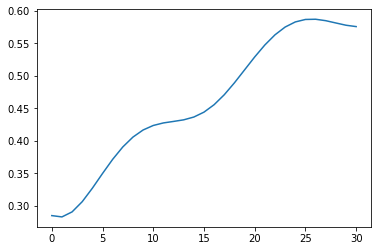

In [56]:
id = 223 #observations: from 0-200, lengths are either oscillating or decreasing. after 200, lengths are increasing
plt.plot(lengthsAll[id])

In [35]:
np.sum((np.array(lengthsFinal)-np.array(lengthsInit))<0)

74

In [32]:
len(lengthsFinal)

313

Compute and plot $\lambda$

8.488856290736424


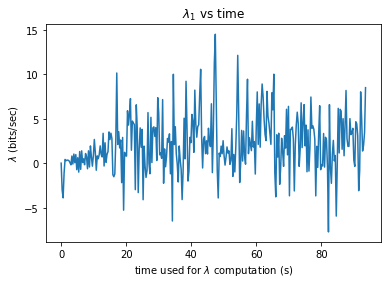

In [57]:
lamAll = []
for i in range(niter):
    # lam = lam + np.log2(lengthsFinal[i]/lengthsInit[i])/(t[niter*tevol]-t[0])

    lam = 0

    for j in range(i):
        lam = lam + np.log2(lengthsFinal[i]/lengthsInit[i])/(t[(i+1)*tevol]-t[0])
    lamAll.append(lam)
    
plt.plot(t[:niter*tevol:tevol],lamAll, '-')
plt.xlabel(r'time used for $\lambda$ computation (s)')
plt.ylabel(r'$\lambda$ (bits/sec)')
plt.title(r'$\lambda_1$ vs time ')
# plt.xlim(0, 10)
# plt.ylim(-3, 3)
print(lam)


In [16]:
[0]*10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

(-0.1, 100.0)

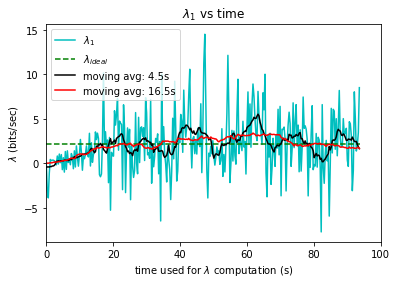

In [17]:
# plt.style.use('plot_style.txt')
plt.plot(t[:niter*tevol:tevol],lamAll, 'c-')
plt.xlabel(r'time used for $\lambda$ computation (s)')
plt.ylabel(r'$\lambda$ (bits/sec)')
plt.title(r'$\lambda_1$ vs time ')
# plt.xlim(0, 40)
# plt.ylim(-3, 10)
plt.plot([0, t[niter*tevol]], [2.16,2.16], 'g--')

npt = 15
ntim = npt*tevol*dt
nptby2 = math.floor(npt/2)
lamAll_padded = [0]*nptby2 +lamAll + [0]*nptby2

lamAll_avg = [np.mean(np.array(lamAll_padded[i-nptby2:i+nptby2+1])) for i in range(nptby2, len(lamAll_padded)-nptby2)]
plt.plot(t[:niter*tevol:tevol],lamAll_avg, 'k-')

nptx = 55
ntimx = nptx*tevol*dt
nptby2x = math.floor(nptx/2)
lamAll_paddedx = [0]*nptby2x +lamAll + [0]*nptby2x

lamAll_avgx = [np.mean(np.array(lamAll_paddedx[i-nptby2x:i+nptby2x+1])) for i in range(nptby2x, len(lamAll_paddedx)-nptby2x)]
plt.plot(t[:niter*tevol:tevol],lamAll_avgx, 'r-')

plt.legend([r'$\lambda_1$',r'$\lambda_{ideal}$', 'moving avg: '+str(ntim)+'s', 'moving avg: '+str(ntimx)+'s'])
plt.xlim(-0.1,100)
# fig = plt.gcf()
# fig.set_size_inches(16.5, 8.5)

(-0.1, 100.0)

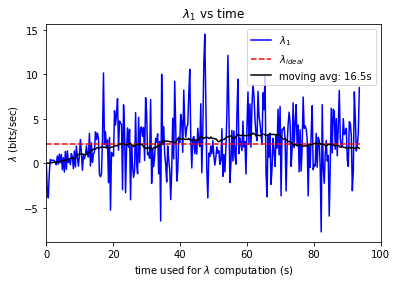

In [18]:
# plt.style.use('plot_style.txt')
plt.plot(t[:niter*tevol:tevol],lamAll, 'b-')
plt.xlabel(r'time used for $\lambda$ computation (s)')
plt.ylabel(r'$\lambda$ (bits/sec)')
plt.title(r'$\lambda_1$ vs time ')
# plt.xlim(0, 40)
# plt.ylim(-3, 10)
plt.plot([0, t[niter*tevol]], [2.16,2.16], 'r--')

npt = 55
ntim = npt*tevol*dt
nptby2 = math.floor(npt/2)
lamAll_padded = [0]*nptby2 +lamAll + [0]*nptby2

lamAll_avg = [np.mean(np.array(lamAll_padded[i-nptby2:i+nptby2+1])) for i in range(nptby2, len(lamAll_padded)-nptby2)]
plt.plot(t[:niter*tevol:tevol],lamAll_avg, 'k-')
plt.legend([r'$\lambda_1$',r'$\lambda_{ideal}$', 'moving avg: '+str(ntim)+'s'])
plt.xlim(-0.1,100)
# fig = plt.gcf()
# fig.set_size_inches(16.5, 8.5)

In [19]:
print(np.mean(lamAll))

2.1659068889099724


In [20]:
print(np.mean(lamAll[-50:]))

2.1676847270211668


In [21]:
len(lamAll)

313

**$\lambda\approx2.16$** is obtained from the average of the last 15s, which is close to $\lambda_{actual}=2.16$

# Recurrence Plots

In [22]:
Np = 1000

In [23]:
RecurrencePlot = np.zeros((Np, Np))

In [24]:
tic = time.time()
for i in range(Np):
    for j in range(Np):
        RecurrencePlot[i,j] = np.linalg.norm(yd[i,:]- yd[j,:])
        
print(f"time taken={time.time()-tic}s")

time taken=7.884868860244751s


Text(0.5, 1.0, 'Recurrence Plot: Lorenz Attractor with 1000 points')

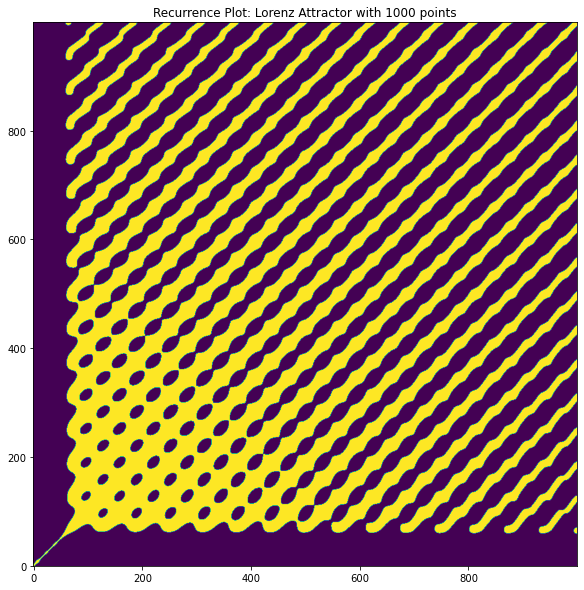

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(RecurrencePlot<3, origin='lower')
ax.set_title(f"Recurrence Plot: Lorenz Attractor with {Np} points")

In [26]:
rp_bin = (RecurrencePlot<3).astype('float')

In [27]:
rp_bin.shape

(1000, 1000)

(100.0, 700.0)

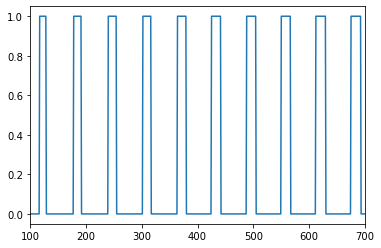

In [28]:
plt.plot(rp_bin[:,-1])
plt.xlim(100, 700)

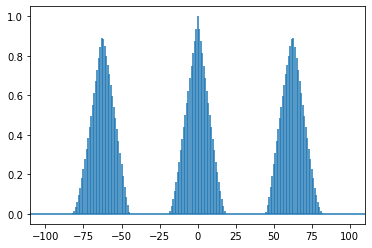

In [29]:
plt.acorr(rp_bin[:,-1], maxlags=100)
# plt.xlim(-5,5)
plt.show()